# Week 8 核心 Action

In [1]:
# -*- coding: utf-8 -*-
# 美吉姆股票收盘价走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

#### 数据加载
##### 这里使用utf-8会报错，所以改用gb2312来decode
##### 表中的price下载的是收盘价

In [2]:
warnings.filterwarnings('ignore')

df = pd.read_csv('./002621.csv',encoding ='gb2312')
df = df[['Timestamp', 'Price']]

##### 将时间作为df的索引

In [3]:
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
print(df.head())

            Timestamp  Price
Timestamp                   
2020-10-16 2020-10-16   7.07
2020-10-15 2020-10-15   7.04
2020-10-14 2020-10-14   6.85
2020-10-13 2020-10-13   6.95
2020-10-12 2020-10-12   6.96


##### 通过上面的数据探索，我们发现，日期是从后往前，也就是老的日期反而在下面了
##### 所以重新做一个升序排序

In [4]:
df = df.sort_index(axis = 0,ascending = True)

In [5]:
# 数据探索，现在日期排序为升序
print(df.head())

            Timestamp  Price
Timestamp                   
2011-09-20 2011-09-20   0.00
2011-09-29 2011-09-29  24.08
2011-09-30 2011-09-30  22.69
2011-10-10 2011-10-10  23.60
2011-10-11 2011-10-11  24.13


In [6]:
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)
#print(df_Q)
#print(df_year)

                Price
Timestamp            
2011-09-30  15.590000
2011-10-31  25.367500
2011-11-30  26.827727
2011-12-31  22.894545
2012-01-31  20.243333
...               ...
2020-06-30   7.218500
2020-07-31   7.094783
2020-08-31   7.286190
2020-09-30   6.739091
2020-10-31   6.955000

[110 rows x 1 columns]


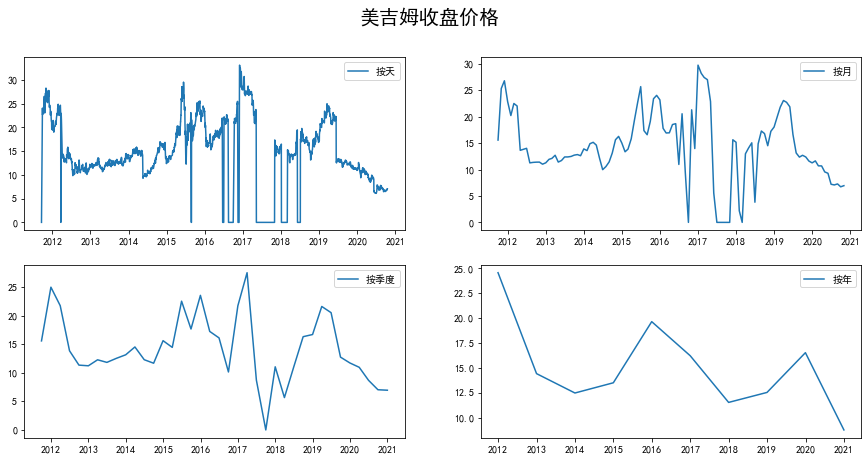

In [7]:
# 按照天，月，季度，年来显示美吉姆股票的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('美吉姆收盘价格', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

##### 设置arma模型的超参数q和p的范围，之后从范围中选择一个好的值
##### 这里parameter_list会把p和q存成一个元组的list，每个元组是它们两个值的组合比如（0，0），（1，0）

In [8]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
parameters = product(ps, qs)
parameters_list = list(parameters)

##### 寻找最优ARMA模型参数，即best_aic最小
##### 方法就是通过一个循环把超参数范围内的值全部代入进去，把aic值最小的模型打印出来

In [9]:

results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  110
Model:                     ARMA(1, 0)   Log Likelihood                -325.754
Method:                       css-mle   S.D. of innovations              4.662
Date:                Tue, 20 Oct 2020   AIC                            657.507
Time:                        18:37:31   BIC                            665.609
Sample:                    09-30-2011   HQIC                           660.793
                         - 10-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.2596      1.449      9.841      0.000      11.420      17.100
ar.L1.Price     0.6994      0.067     10.366      0.000       0.567       0.832
                                    Roots

### 预测未来三个月的收盘价，以月来统计

In [10]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])

In [11]:
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

date_list= [Timestamp('2020-11-30 00:00:00', freq='M'), Timestamp('2020-12-31 00:00:00', freq='M'), Timestamp('2021-01-31 00:00:00', freq='M')]


In [12]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

In [13]:
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))

In [14]:
print(df_month2)

                Price   forecast
2011-09-30  15.590000  14.259620
2011-10-31  25.367500  15.190130
2011-11-30  26.827727  22.028819
2011-12-31  22.894545  23.050148
2012-01-31  20.243333  20.299157
...               ...        ...
2020-09-30   6.739091   9.382185
2020-10-31   6.955000   8.999527
2020-11-30        NaN   9.150540
2020-12-31        NaN  10.686170
2021-01-31        NaN  11.760237

[113 rows x 2 columns]


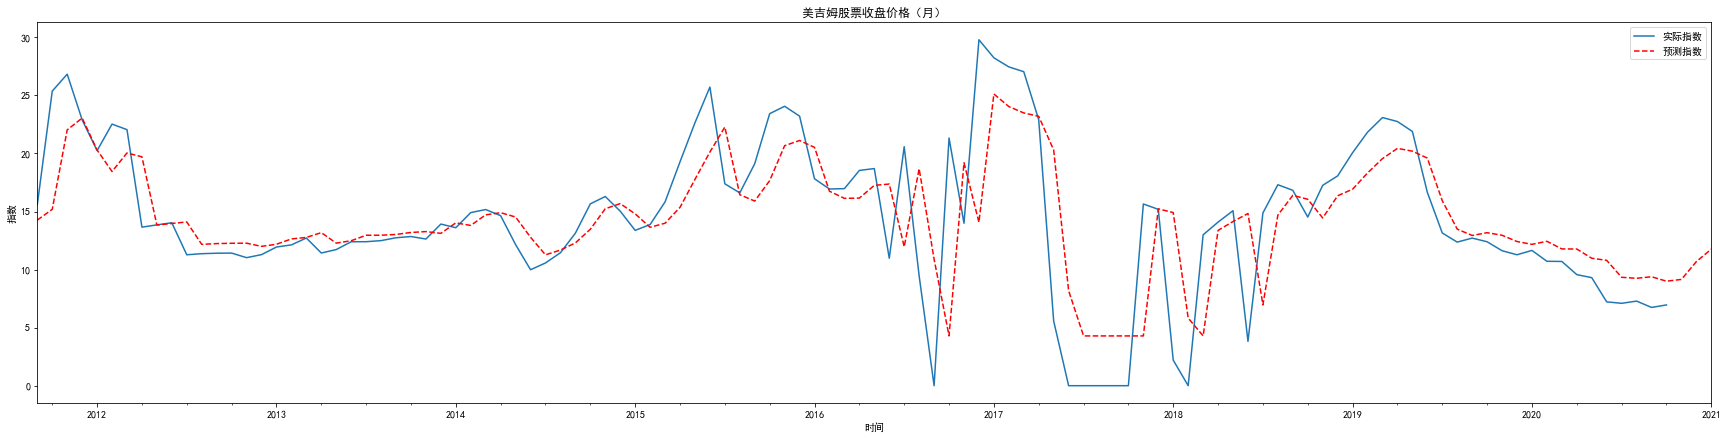

In [15]:
#预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('美吉姆股票收盘价格（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()